# Ensemble Learning

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from collections import Counter

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix

## Read the CSV and Perform Basic Data Cleaning

In [4]:
# Load the data
file_path = Path('Resources/LoanStats_2019Q1.csv')
df = pd.read_csv(file_path)

# Preview the data
df.head()

,loan_amnt,int_rate,installment,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,dti,...,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,debt_settlement_flag
0,10500.0,0.1719,375.35,RENT,66000.0,Source Verified,Mar-2019,low_risk,n,27.24,...,85.7,100.0,0.0,0.0,65687.0,38199.0,2000.0,61987.0,N,N
1,25000.0,0.2000,929.09,MORTGAGE,105000.0,Verified,Mar-2019,low_risk,n,20.23,...,91.2,50.0,1.0,0.0,271427.0,60641.0,41200.0,49197.0,N,N
2,20000.0,0.2000,529.88,MORTGAGE,56000.0,Verified,Mar-2019,low_risk,n,24.26,...,66.7,50.0,0.0,0.0,60644.0,45684.0,7500.0,43144.0,N,N
3,10000.0,0.1640,353.55,RENT,92000.0,Verified,Mar-2019,low_risk,n,31.44,...,100.0,50.0,1.0,0.0,99506.0,68784.0,19700.0,76506.0,N,N
4,22000.0,0.1474,520.39,MORTGAGE,52000.0,Not Verified,Mar-2019,low_risk,n,18.76,...,100.0,0.0,0.0,0.0,219750.0,25919.0,27600.0,20000.0,N,N


## Split the Data into Training and Testing

In [5]:
# Create our features
X = df.drop(columns = ["loan_status", 
                       "home_ownership", 
                       "verification_status", 
                       "issue_d",
                       "pymnt_plan",
                       "initial_list_status",
                       "next_pymnt_d",
                       "application_type",
                       "hardship_flag",
                       "debt_settlement_flag"
                      ]
           )

# Create our target
y = df["loan_status"]

In [6]:
X.describe()

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,68817.000000,68817.000000,68817.000000,6.881700e+04,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,...,68817.000000,68817.000000,68817.000000,68817.000000,68817.000000,68817.0,6.881700e+04,6.881700e+04,68817.000000,6.881700e+04
mean,16677.594562,0.127718,480.652863,8.821371e+04,21.778153,0.217766,0.497697,12.587340,0.126030,17604.142828,...,0.052138,2.219423,95.057627,30.626217,0.125972,0.0,2.100332e+05,6.133843e+04,29734.128558,5.572240e+04
std,10277.348590,0.048130,288.062432,1.155800e+05,20.199244,0.718367,0.758122,6.022869,0.336797,21835.880400,...,0.390633,1.897432,8.326426,33.631463,0.336732,0.0,1.928088e+05,5.738798e+04,26795.394232,5.095845e+04
min,1000.000000,0.060000,30.890000,4.000000e+01,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,0.000000,20.000000,0.000000,0.000000,0.0,3.600000e+03,2.350000e+02,100.000000,1.270000e+02
25%,9000.000000,0.088100,265.730000,5.000000e+04,13.890000,0.000000,0.000000,8.000000,0.000000,6293.000000,...,0.000000,1.000000,93.000000,0.000000,0.000000,0.0,6.697700e+04,2.650300e+04,11600.000000,2.288000e+04
50%,15000.000000,0.118000,404.560000,7.300000e+04,19.760000,0.000000,0.000000,11.000000,0.000000,12068.000000,...,0.000000,2.000000,100.000000,20.000000,0.000000,0.0,1.467100e+05,4.535700e+04,22100.000000,4.200000e+04
75%,24000.000000,0.155700,648.100000,1.040000e+05,26.660000,0.000000,1.000000,16.000000,0.000000,21735.000000,...,0.000000,3.000000,100.000000,50.000000,0.000000,0.0,3.036400e+05,7.657000e+04,39300.000000,7.249900e+04
max,40000.000000,0.308400,1676.230000,8.797500e+06,999.000000,18.000000,5.000000,72.000000,4.000000,587191.000000,...,18.000000,19.000000,100.000000,100.000000,4.000000,0.0,3.292782e+06,1.295455e+06,509400.000000,1.426964e+06


In [7]:
# Check the balance of our target values
y.value_counts()

low_risk     68470
high_risk      347
Name: loan_status, dtype: int64

In [8]:
# Split the X and y into X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 1,
                                                    stratify = y
                                                   )
X_train.shape

(51612, 76)

## Data Pre-Processing

In [9]:
# Create the StandardScaler instance
scaler = StandardScaler()

In [10]:
# Fit the Standard Scaler with the training data
# When fitting scaling functions, only train on the training dataset
X_scaler = scaler.fit(X_train)

In [11]:
# Scale the training and testing data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Balanced Random Forest Classifier

In [21]:
# Resample the training data with the BalancedRandomForestClassifier
brfc_model = BalancedRandomForestClassifier(n_estimators = 1000, random_state = 1)
brfc_model.fit(X_train_scaled, y_train)
Counter(y_train)

Counter({'low_risk': 51352, 'high_risk': 260})

In [22]:
# Calculated the balanced accuracy score
y_pred_brfc = brfc_model.predict(X_test_scaled)
balanced_accuracy_score(y_test, y_pred_brfc)

0.7406521064739274

In [23]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_brfc)

array([[   54,    33],
       [ 2386, 14732]])

In [15]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_brfc))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.62      0.86      0.04      0.73      0.52        87
   low_risk       1.00      0.86      0.62      0.92      0.73      0.55     17118

avg / total       0.99      0.86      0.62      0.92      0.73      0.55     17205



[(0.07157382313274996, 'total_rec_prncp'),
 (0.06775959347731268, 'total_rec_int'),
 (0.06214121353543022, 'last_pymnt_amnt'),
 (0.054448826598895585, 'total_pymnt_inv'),
 (0.05440801418793802, 'total_pymnt'),
 (0.029572556535760113, 'int_rate'),
 (0.01921112881803294, 'dti'),
 (0.019011552669451696, 'annual_inc'),
 (0.01799259011912974, 'il_util'),
 (0.017731544282880318, 'mths_since_recent_inq'),
 (0.01766284306868225, 'max_bal_bc'),
 (0.0171102321910767, 'mo_sin_old_il_acct'),
 (0.0166476912857524, 'installment'),
 (0.016604731216916573, 'bc_util'),
 (0.01654748122133624, 'avg_cur_bal'),
 (0.016398138419554658, 'out_prncp_inv'),
 (0.016246123627819468, 'tot_hi_cred_lim'),
 (0.015823571963239712, 'revol_bal'),
 (0.015708758438789758, 'out_prncp'),
 (0.015701024104325154, 'mo_sin_old_rev_tl_op'),
 (0.015634345961864325, 'tot_cur_bal'),
 (0.015007514609349529, 'bc_open_to_buy'),
 (0.014985864850130256, 'total_bc_limit'),
 (0.014870532991540867, 'mths_since_rcnt_il'),
 (0.01462212865847

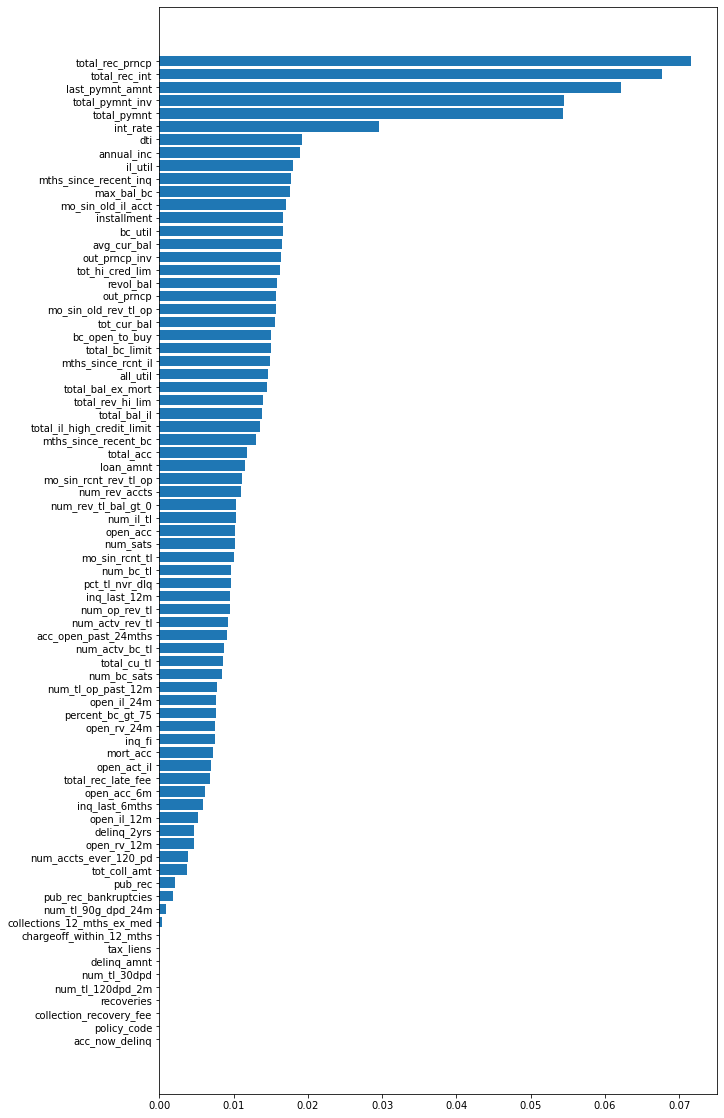

In [53]:
# List the features sorted in descending order by feature importance
importances = brf_model.feature_importances_
importances_sorted = sorted(zip(brf_model.feature_importances_, X.columns), reverse = True)
display(importances_sorted)

# Plot Importances
indices = np.argsort(importances)
fig, ax = plt.subplots(figsize=(10,20))
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(X_train.columns)[indices])

## Easy Ensemble Classifier

In [17]:
# Train the Classifier
eec_model = EasyEnsembleClassifier(random_state = 1)
eec_model.fit(X_train, y_train)

EasyEnsembleClassifier(random_state=1)

In [18]:
# Calculated the balanced accuracy score
y_pred_eec = eec_model.predict(X_test)
print(balanced_accuracy_score(y_test, y_pred_eec))

0.7339642481598317


In [19]:
# Display the confusion matrix
confusion_matrix(y_test, y_pred_eec)

array([[   58,    29],
       [ 3402, 13716]])

In [20]:
# Print the imbalanced classification report
print(classification_report_imbalanced(y_test, y_pred_eec))

                   pre       rec       spe        f1       geo       iba       sup

  high_risk       0.02      0.67      0.80      0.03      0.73      0.53        87
   low_risk       1.00      0.80      0.67      0.89      0.73      0.54     17118

avg / total       0.99      0.80      0.67      0.88      0.73      0.54     17205



### Final Questions

1. Which model had the best balanced accuracy score?

    Balanced Random Forest Classifier.

2. Which model had the best recall score?

    Balanced Random Forest Classifier.

3. Which model had the best geometric mean score?

    Both.

4. What are the top three features?

    total_rec_prncp, total_rec_int, last_pymnt_amnt.